This notebook is used to generate cluster based labels for Altered movielens dataset

In [1]:
%matplotlib inline

In [1]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

/home/ubuntu/anaconda3/envs/celeba/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use('ggplot')

In [3]:
# class MovieLensCNN(nn.Module):
#     def __init__(self, n_classes):
#         super(MovieLensCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         #self.conv2 = nn.Conv2d(32, 64, 5)
#         self.fc1 = nn.Linear(107520, 2048)
#         self.output = nn.Linear(2048, n_classes)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         #x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 107520)
#         x = F.relu(self.fc1(x))
#         x = self.output(x)
#         return x
    
# model = MovieLensCNN(5)

In [4]:
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
# import torchvision.models as models

# model = models.mobilenet_v2()
# model.classifier[1] = nn.Linear(model.last_channel, 10)

In [6]:
# model(torch.zeros((2,3,10,10)))

In [7]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [8]:
ratings = pd.read_csv("/home/ubuntu/code/FedEM/data/movieLens/ml-latest-small/ratings.csv")

In [10]:
ratings.movieId.unique()

array([     1,      3,      6, ..., 160836, 163937, 163981])

In [11]:
# ratings = ratings[ratings['userId']<=20000]
# ratings.head()

In [12]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)


In [13]:
(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 610 users, 9724 movies
Dataset shape: (100836, 2)
Target shape: (100836,)


In [14]:
X.user_id.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [15]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [16]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1) 

In [17]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[ 145,  470],
        [ 379,  113],
        [ 479,  192],
        [ 413, 1002]])
tensor([[2.0000],
        [4.0000],
        [4.5000],
        [3.0000]])


In [18]:
m

9724

In [19]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [20]:
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(610, 150)
  (m): Embedding(9724, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [21]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [22]:
minmax = ratings.rating.min().astype(float), ratings.rating.max().astype(float)
minmax

(0.5, 5.0)

In [23]:
net = EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

In [24]:
net

EmbeddingNet(
  (u): Embedding(610, 150)
  (m): Embedding(9724, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [25]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]


lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

/home/ubuntu/anaconda3/envs/celeba/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss improvement on epoch: 1
[001/100] train: 1.0400 - val: 0.8356
loss improvement on epoch: 2
[002/100] train: 0.7548 - val: 0.7909
loss improvement on epoch: 3
[003/100] train: 0.7125 - val: 0.7674
loss improvement on epoch: 4
[004/100] train: 0.6579 - val: 0.7620
[005/100] train: 0.6639 - val: 0.7626
[006/100] train: 0.6281 - val: 0.7636
loss improvement on epoch: 7
[007/100] train: 0.6415 - val: 0.7615
loss improvement on epoch: 8
[008/100] train: 0.6086 - val: 0.7615
[009/100] train: 0.6220 - val: 0.7657
[010/100] train: 0.5938 - val: 0.7683
[011/100] train: 0.6066 - val: 0.7671
[012/100] train: 0.5822 - val: 0.7700
[013/100] train: 0.5965 - val: 0.7739
[014/100] train: 0.5706 - val: 0.7753
[015/100] train: 0.5873 - val: 0.7787
[016/100] train: 0.5650 - val: 0.7791
[017/100] train: 0.5794 - val: 0.7779
[018/100] train: 0.5579 - val: 0.7825
early stopping after epoch 018


In [26]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [27]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8895


In [28]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [29]:
def to_numpy(tensor):
    return tensor.cpu().numpy()

In [30]:
embed = to_numpy(net.u.weight.data)

# kmeans = KMeans(n_clusters=int(2), random_state=0).fit(embed)

In [31]:
n_clusters = [i for i in range(1,30, 2)]
wss = []

for cluster_centers in n_clusters:
    print(cluster_centers)
    kmeans = KMeans(n_clusters=int(cluster_centers), random_state=0).fit(embed)
    wss.append(kmeans.inertia_)

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29


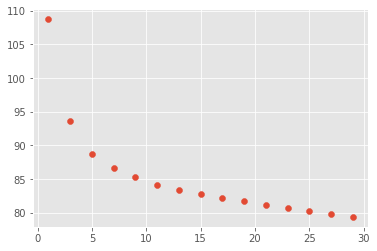

In [32]:
import matplotlib.pyplot as plt

plt.scatter(n_clusters, wss)

In [33]:
pca = PCA(n_components=2)
components = pca.fit_transform(embed)

In [34]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(embed)

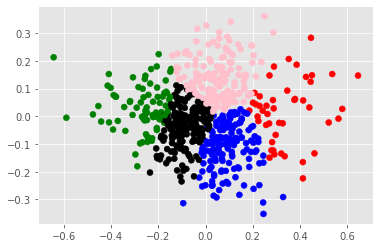

In [35]:
import matplotlib.pyplot as plt
colors = ["red","green","blue","black","pink", "yellow","orange","purple","beige","brown","gray","cyan"]
c = [colors[label] for label in kmeans.labels_]
plt.scatter(components[:,0], components[:,1], c=c)
plt.show()

In [30]:
colors = ["red","green","blue","yellow","pink"]

In [64]:
colors[kmeans.labels_]

TypeError: only integer scalar arrays can be converted to a scalar index

In [36]:
c = [colors[label] for label in kmeans.labels_]

In [37]:
kmeans.labels_

array([1, 3, 0, 4, 2, 3, 4, 4, 4, 2, 3, 1, 3, 4, 2, 2, 3, 2, 0, 4, 2, 0,
       2, 2, 1, 2, 3, 0, 4, 1, 3, 3, 4, 2, 1, 0, 3, 2, 3, 3, 2, 3, 1, 3,
       3, 1, 2, 1, 3, 0, 4, 1, 1, 0, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 3, 3,
       3, 2, 1, 3, 3, 4, 3, 3, 0, 0, 3, 2, 3, 1, 0, 2, 2, 3, 4, 3, 3, 4,
       2, 1, 2, 3, 1, 2, 3, 4, 1, 4, 1, 3, 4, 2, 3, 2, 3, 1, 1, 4, 2, 4,
       2, 4, 4, 0, 3, 2, 2, 2, 1, 3, 2, 1, 3, 4, 3, 2, 0, 3, 3, 3, 0, 0,
       2, 3, 4, 3, 2, 3, 0, 2, 2, 3, 2, 2, 2, 4, 2, 2, 0, 3, 3, 4, 0, 1,
       3, 4, 2, 2, 2, 4, 3, 1, 2, 1, 2, 3, 4, 4, 1, 2, 1, 3, 2, 3, 4, 1,
       2, 4, 3, 2, 2, 4, 3, 4, 3, 1, 4, 1, 3, 4, 4, 1, 0, 2, 2, 3, 2, 4,
       4, 3, 1, 3, 3, 4, 2, 4, 2, 2, 4, 1, 3, 2, 3, 2, 4, 4, 2, 4, 4, 3,
       4, 2, 0, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 4, 4, 2, 2, 3, 1, 2, 3,
       1, 4, 0, 1, 2, 2, 3, 1, 1, 4, 3, 3, 0, 3, 2, 4, 0, 2, 4, 2, 3, 2,
       2, 4, 3, 4, 3, 4, 2, 2, 1, 2, 4, 1, 3, 3, 2, 3, 2, 3, 2, 3, 4, 3,
       4, 2, 4, 4, 3, 2, 2, 0, 4, 4, 4, 0, 3, 3, 4,

In [38]:
with open('/home/ubuntu/code/FedEM/data/movieLens/labels.npy', 'wb') as f:
    np.save(f, kmeans.labels_)

In [39]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [40]:
ratings.rating

0         4.0
1         4.0
2         4.0
3         5.0
4         5.0
         ... 
100831    4.0
100832    5.0
100833    5.0
100834    5.0
100835    3.0
Name: rating, Length: 100836, dtype: float64

In [41]:
X_modified = X

In [42]:
Y = y.to_numpy()

In [43]:
Y = (Y-np.mean(Y))/np.std(Y)

In [44]:
modified_ratings = np.zeros((n,m))

In [45]:
for index, row in X_modified.iterrows():
    modified_ratings[row['user_id'], row['movie_id']] = Y[index]

In [45]:
modified_ratings_1 = modified_ratings[:,:-1]

In [49]:
with open('/home/ubuntu/code/FedEM/data/movieLens/ratings.npy', 'wb') as f:
    np.save(f, modified_ratings.reshape(-1,143,68))

In [46]:
modified_ratings.shape # 163981

(610, 9724)

In [47]:
9724/143

68.0

In [42]:
modified_ratings.reshape(-1,1,68,143).shape

(610, 1, 68, 143)

In [132]:
9724/4

2431.0

In [52]:
kmeans.labels_.shape

(610,)

In [60]:
modified_ratings.shape

(610, 9724)

In [56]:
modified_ratings.shape

(3000, 16782)

In [39]:
modified_ratings.shape

(610, 9724)

In [41]:
68*143

9724

In [ ]:
modified_ratings_1.shape

In [37]:
modified_ratings_1

NameError: name 'modified_ratings_1' is not defined

In [ ]:
64, 13, 75